# Typeform - Employee Churn Analysis & Prediction

In [1]:
from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import cufflinks as cf
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
# from xgboost import XGBClassifier

In [3]:
plt.rcParams["figure.figsize"] = (10,6)

In [4]:
pd.options.plotting.backend = 'plotly'

## Data

In [5]:
df = pd.read_csv('./data/typeform-public-clean.csv')

In [6]:
df.set_index('EEID', inplace=True)

In [7]:
df.head()

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Job Information: Date,Division,...,Supervisor EID,Pay rate,Pay rate - Currency code,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,Undergraduate degree (Grado),2019-08-19,2019-09-30,Involuntary,End of contract,2019-08-19,People,...,1,6047.0,EUR,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1
468,Inactive,29,Male,Unknown,2016-07-05,2017-03-30,Involuntary,End of contract,2016-07-05,Engineering,...,234,6144.0,EUR,Unknown,N,Unknown,No,"8 months, 25 days",0,8
458,Inactive,27,Male,Unknown,2016-09-05,2017-01-26,Involuntary,End of contract,2016-09-05,Engineering,...,0,6144.0,EUR,Unknown,N,Unknown,No,"4 months, 21 days",0,4
379,Inactive,25,Male,Undergraduate degree (Grado),2017-10-23,2018-08-28,Involuntary,End of contract,2017-10-23,Engineering,...,0,6144.0,EUR,New hire,N,Unknown,No,"10 months, 5 days",0,10
492,Inactive,58,Female,Unknown,2017-09-13,2017-09-29,Involuntary,End of contract,2017-09-13,People,...,0,7200.0,EUR,Unknown,N,Unknown,No,16 days,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 343 to 721
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Status                      607 non-null    object 
 1   Age                         607 non-null    int64  
 2   Gender                      607 non-null    object 
 3   Education Level             607 non-null    object 
 4   Hire Date                   607 non-null    object 
 5   Termination Date            258 non-null    object 
 6   Termination Type            258 non-null    object 
 7   Termination Reason          254 non-null    object 
 8   Job Information: Date       607 non-null    object 
 9   Division                    607 non-null    object 
 10  Department                  607 non-null    object 
 11  Supervisor EID              607 non-null    int64  
 12  Pay rate                    607 non-null    float64
 13  Pay rate - Currency code    607 n

## Data wrangling

In [9]:
df['Attrition'] = pd.get_dummies(df['Termination Type'], drop_first=True)

In [10]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'USD', df['Pay rate'] * 0.82 * (1-0.38), df['Pay rate'])
# también funcionaría con lo siguiente, pero me queda mas claro usando np.where: df.apply(lambda x: (x['Pay rate'] * 0.82) if x['Pay rate - Currency code'] == 'USD' else x['Pay rate'], axis=1)

In [11]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'GBP', df['Pay rate'] * 1.16 * (1-0.41), df['Pay rate EUR'])

In [12]:
# Para comprobar que está bien:
df[['Pay rate', 'Pay rate - Currency code', 'Pay rate EUR']][df['Pay rate - Currency code'] == 'GBP']

,Pay rate,Pay rate - Currency code,Pay rate EUR
EEID,,,
700,41600.0,GBP,28471.04
697,44000.0,GBP,30113.60
779,44000.0,GBP,30113.60
698,56000.0,GBP,38326.40
774,68000.0,GBP,46539.20
757,68000.0,GBP,46539.20
731,96000.0,GBP,65702.40
161,99200.0,GBP,67892.48


In [13]:
# Location
df['Location'] = df.apply(lambda x: 'North America' if x['Pay rate - Currency code'] == 'USD' else 'Europe', axis=1)

In [14]:
# Reordenamos las columnas para que quede más claro:
df = df[['Status', 'Age', 'Gender', 'Education Level', 'Hire Date', 
       'Termination Date', 'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department', 'Supervisor EID',
       'Pay rate', 'Pay rate - Currency code', 'Pay rate EUR', 'Compensation Change Reason',
       'Stock Options', 'Level', 'Is Supervisor', 'Length of service',
       'Length of service: Years', 'Length of service: Months']]

In [15]:
df['Age bracket'] = pd.cut(df['Age'], bins = [18, 25, 30, 35, 40, 45, 50, 55], labels = [i for i in range(7)])

In [16]:
df['Division'] = df['Division'].apply(lambda x: 'People & Home' if 'People' in x or 'Home' in x else x)

In [17]:
df['Division'] = df['Division'].apply(lambda x: 'Finance & Legal' if 'Finance' in x else x)

In [18]:
df['Division'] = df['Division'].apply(lambda x: 'Leadership' if 'Founders' in x else x)

In [19]:
df.groupby('Division').sum()['Attrition'] / df.groupby('Division').count()['Attrition']

Division
Business Development    0.294118
Customer Success        0.233766
Data & Analytics        0.228070
Design                  0.272727
Engineering             0.382775
Finance & Legal         0.272727
Leadership              0.333333
Marketing               0.327586
People & Home           0.272727
Product                 0.400000
R&D                     0.000000
Security                0.000000
Strategy                0.000000
Unknown                 0.333333
Name: Attrition, dtype: float64

In [20]:
df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1)

In [21]:
df[df['Division'] == 'Unknown']

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,...,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months,Age bracket,Female,Male,Not Specified,Unknown
EEID,,,,,,,,,,,,,,,,,,,,,
428,Inactive,23,Female,Unknown,2018-07-02,2018-08-24,Involuntary,End of contract,0,2018-07-02,...,L0,No,"1 month, 22 days",0,1,0,1,0,0,0
457,Inactive,25,Male,Unknown,2018-09-17,2018-12-17,Involuntary,End of contract,0,2018-09-17,...,Unknown,No,"3 months, 0 days",0,3,0,0,1,0,0
427,Inactive,35,Female,Unknown,2016-07-18,2018-09-07,Voluntary,Other employment,1,2017-10-02,...,Unknown,No,"2 years, 1 month, 20 days",2,26,2,1,0,0,0


In [22]:
df.drop(df.loc[df['Not Specified'] == 1].index, inplace=True)

In [23]:
df.drop(df.loc[df['Unknown'] == 1].index, inplace=True)

In [24]:
df = df.drop(columns=['Male', 'Not Specified', 'Unknown'])

In [25]:
df.drop('Education Level', axis=1, inplace=True)

In [26]:
df['North America'] = pd.get_dummies(df['Location'], drop_first=True)

In [27]:
df.Division.value_counts()

Engineering             207
Customer Success         76
Marketing                58
Data & Analytics         57
People & Home            54
Design                   44
Product                  40
Finance & Legal          22
Business Development     17
Strategy                 11
Security                  8
Unknown                   3
R&D                       3
Leadership                3
Name: Division, dtype: int64

In [28]:
df['Has_stock'] = pd.get_dummies(df['Stock Options'], drop_first=True)

In [29]:
df['Level'].value_counts()
# muchos valores unknown!

E3         157
E2         135
Unknown     68
M1          44
L2          43
L3          30
M3          28
M2          21
E1          20
E4          20
L1           7
C-Level      7
E0           6
M4           5
L4           5
E5           2
L0           2
E6           1
M0           1
L5           1
Name: Level, dtype: int64

In [30]:
df['Level'] = df['Level'].replace('(.*)[^EM](?=\d)','E', regex=True)

In [31]:
df['Level'] = df['Level'].replace('M0', 'M1')

In [32]:
df.head()

,Status,Age,Gender,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,Location,...,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months,Age bracket,Female,North America,Has_stock
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,2019-08-19,2019-09-30,Involuntary,End of contract,0,2019-08-19,Europe,...,N,Unknown,No,"1 month, 11 days",0,1,1,1,0,0
468,Inactive,29,Male,2016-07-05,2017-03-30,Involuntary,End of contract,0,2016-07-05,Europe,...,N,Unknown,No,"8 months, 25 days",0,8,1,0,0,0
458,Inactive,27,Male,2016-09-05,2017-01-26,Involuntary,End of contract,0,2016-09-05,Europe,...,N,Unknown,No,"4 months, 21 days",0,4,1,0,0,0
379,Inactive,25,Male,2017-10-23,2018-08-28,Involuntary,End of contract,0,2017-10-23,Europe,...,N,Unknown,No,"10 months, 5 days",0,10,0,0,0,0
492,Inactive,58,Female,2017-09-13,2017-09-29,Involuntary,End of contract,0,2017-09-13,Europe,...,N,Unknown,No,16 days,0,0,NaN,1,0,0


In [33]:
df.columns

Index(['Status', 'Age', 'Gender', 'Hire Date', 'Termination Date',
       'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department',
       'Supervisor EID', 'Pay rate', 'Pay rate - Currency code',
       'Pay rate EUR', 'Compensation Change Reason', 'Stock Options', 'Level',
       'Is Supervisor', 'Length of service', 'Length of service: Years',
       'Length of service: Months', 'Age bracket', 'Female', 'North America',
       'Has_stock'],
      dtype='object')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 343 to 721
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Status                      603 non-null    object  
 1   Age                         603 non-null    int64   
 2   Gender                      603 non-null    object  
 3   Hire Date                   603 non-null    object  
 4   Termination Date            256 non-null    object  
 5   Termination Type            256 non-null    object  
 6   Termination Reason          252 non-null    object  
 7   Attrition                   603 non-null    uint8   
 8   Job Information: Date       603 non-null    object  
 9   Location                    603 non-null    object  
 10  Division                    603 non-null    object  
 11  Department                  603 non-null    object  
 12  Supervisor EID              603 non-null    int64   
 13  Pay rate          

In [35]:
cols_to_drop = ['Hire Date', 'Termination Date', 'Termination Type', 'Termination Reason', 'Job Information: Date',
                'Department', 'Supervisor EID', 'Pay rate', 'Pay rate - Currency code','Compensation Change Reason', 'Length of service', 
                'Length of service: Years', 'Age bracket', 'Is Supervisor']
# borro las columnas que no vamos a usar

In [36]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [37]:
df.head()

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Stock Options,Level,Length of service: Months,Female,North America,Has_stock
EEID,,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.0,N,Unknown,1,1,0,0
468,Inactive,29,Male,0,Europe,Engineering,6144.0,N,Unknown,8,0,0,0
458,Inactive,27,Male,0,Europe,Engineering,6144.0,N,Unknown,4,0,0,0
379,Inactive,25,Male,0,Europe,Engineering,6144.0,N,Unknown,10,0,0,0
492,Inactive,58,Female,0,Europe,People & Home,7200.0,N,Unknown,0,1,0,0


## Exploratory Data Analysis

**What does attrition mean?**

Employee attrition is the naturally occurring, voluntary departure of employees from a company.

Variable que queremos predecir: **Attrition**

Variables que nos interesan: 

**Numéricas:**
- Age
- Pay rate EUR
- Lenghts of service (months)

**Categóricas:**
- Gender
- Location
- Division
- Stock Options
- Level

**Columnas encoded**: 'Female', 'North America', 'Business Development', 'Customer Success',
       'Data & Analytics', 'Design', 'Engineering', 'Finance & Legal',
       'Leadership', 'Marketing', 'People & Home', 'Product', 'R&D',
       'Security', 'Strategy', 'Has_stock', 'C-Level', 'E0', 'E1', 'E2', 'E3',
       'E4', 'E5', 'E6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'M0', 'M1', 'M2',
       'M3', 'M4', 'Unknown_level', 'Is_Supervisor_enc'


### Numerical variables

#### Age

In [38]:
stats.shapiro(df['Age'])

ShapiroResult(statistic=0.9524832963943481, pvalue=5.08773687242503e-13)

In [39]:
df['Age'].iplot('hist')

#### Pay rate

In [40]:
stats.shapiro(df['Pay rate EUR'])

ShapiroResult(statistic=0.8029524683952332, pvalue=1.9286060625635608e-26)

In [41]:
df['Pay rate EUR'].iplot('hist')

#### Length of service

In [42]:
stats.shapiro(df['Length of service: Months'])

ShapiroResult(statistic=0.8911247253417969, pvalue=3.185232462693613e-20)

In [43]:
df['Length of service: Months'].iplot('hist')

### Categorical variables

#### Gender

In [44]:
px.bar(df['Gender'].value_counts())

#### Location

In [45]:
px.bar(df['Location'].value_counts())

#### Division

In [46]:
px.bar(df['Division'].value_counts())

#### Stock Options

In [47]:
px.bar(df['Stock Options'].value_counts())

#### Level

In [48]:
px.bar(df['Level'].value_counts())

## Hypothesis testing

### Continuous variables - Mann Whitney Test

In [49]:
not_attrition = df[df['Attrition'] == 0]
attrition = df[df['Attrition'] == 1]

#### Pay rate

In [50]:
stats.mannwhitneyu(not_attrition['Pay rate EUR'], attrition['Pay rate EUR'])


MannwhitneyuResult(statistic=36708.0, pvalue=0.1470652209107165)

We accept the H0, therefore there's no significant difference on the salary between those who have been attrition and those who have not.

In [51]:
df[['Attrition', 'Pay rate EUR']].pivot(columns='Attrition', values='Pay rate EUR').iplot(kind='box')

In [52]:
df.shape

(603, 13)

In [53]:
q25 = df['Pay rate EUR'].describe()[4]
q75 = df['Pay rate EUR'].describe()[6]

In [54]:
iqr = q75 - q25
iqr

20600.0

In [55]:
cut_off = iqr * 1.5

In [56]:
lower, upper = q25 - cut_off, q75 + cut_off
lower, upper

(1100.0, 83500.0)

In [57]:
not_outliers = [x for x in df['Pay rate EUR'] if x > lower and x < upper]

In [58]:
df = df[df['Pay rate EUR'].isin(not_outliers)]

After removing the outliers...

In [59]:
df.shape

(573, 13)

#### Age

In [60]:
stats.mannwhitneyu(not_attrition['Age'], attrition['Age'])

MannwhitneyuResult(statistic=38483.0, pvalue=0.44005710982192214)

We accept the H0, therefore there's no significant difference on the age between those who have been attrition and those who have not.

In [61]:
df[['Attrition', 'Age']].pivot(columns='Attrition', values='Age').iplot(kind='box')

In [62]:
df.shape

(573, 13)

In [63]:
q25 = df['Age'].describe()[4]
q75 = df['Age'].describe()[6]

In [64]:
iqr = q75 - q25
iqr

7.0

In [65]:
cut_off = iqr * 1.5

In [66]:
lower, upper = q25 - cut_off, q75 + cut_off
lower, upper

(19.5, 47.5)

In [67]:
not_outliers = [x for x in df['Age'] if x > lower and x < upper]

In [68]:
df = df[df['Age'].isin(not_outliers)]

After removing the outliers...

In [69]:
df.shape

(562, 13)

#### Length of service

In [70]:
stats.mannwhitneyu(not_attrition['Length of service: Months'], attrition['Length of service: Months'])

MannwhitneyuResult(statistic=24907.0, pvalue=1.0770431451273054e-12)

We reject the H0, therefore in this case there is significant difference on the length of service between those who have been attrition and those who have not.

In [71]:
df[['Attrition', 'Length of service: Months']].pivot(columns='Attrition', values='Length of service: Months').iplot(kind='box')

In [72]:
df.shape

(562, 13)

In [73]:
q25 = df['Length of service: Months'].describe()[4]
q75 = df['Length of service: Months'].describe()[6]

In [74]:
iqr = q75 - q25
iqr

21.0

In [75]:
cut_off = iqr * 1.5
cut_off

31.5

In [76]:
upper = q75 + cut_off
upper

61.5

In [77]:
not_outliers = [x for x in df['Length of service: Months'] if x < upper]

In [78]:
df = df[df['Length of service: Months'].isin(not_outliers)]

After removing the outliers...

In [79]:
df.shape

(544, 13)

### Discrete variables - Chi2

#### Gender

In [80]:
df_gender = pd.DataFrame(df.groupby('Gender').sum()['Attrition'])

In [81]:
df_gender['Not_Attrition'] = df.groupby('Gender').count()['Attrition'] - df_gender['Attrition']
df_gender

,Attrition,Not_Attrition
Gender,,
Female,61,125
Male,110,248


In [82]:
chi2, p_value, dof, expected = stats.chi2_contingency(df_gender)
p_value

0.6922335275371927

The p-value is way above 0.05, therefore we accept the H0, and there is not significant difference on the gender between those who have been attrition and those who have not.

#### Location

In [83]:
df_location = pd.DataFrame(df.groupby('Location').sum()['Attrition'])

In [84]:
df_location['Not_Attrition'] = df.groupby('Location').count()['Attrition'] - df_location['Attrition']
df_location

,Attrition,Not_Attrition
Location,,
Europe,161,331
North America,10,42


In [85]:
chi2, p_value, dof, expected = stats.chi2_contingency(df_location)
p_value

0.06634690384046787

The p-value is above 0.05, therefore we accept the H0, and we conclude there is not significant difference on the location between those who have been attrition and those who have not.

#### Division

In [86]:
df_division = pd.DataFrame(df.groupby('Division').sum()['Attrition'])

In [87]:
df_division['Not_Attrition'] = df.groupby('Division').count()['Attrition'] - df_division['Attrition']

In [88]:
df_division

,Attrition,Not_Attrition
Division,,
Business Development,4,12
Customer Success,16,53
Data & Analytics,13,40
Design,12,29
Engineering,73,119
Finance & Legal,5,13
Marketing,17,34
People & Home,15,35
Product,15,18


In [89]:
chi2, p_value, dof, expected = stats.chi2_contingency(df_division)
p_value

0.08561547921702146

The p-value is a bit above 0.05, therefore we accept the H0, and we conclude there is not significant difference on the division between those who have been attrition and those who have not.

In [90]:
df_division['Proportion'] = df_division['Attrition'] / (df_division['Attrition'] + df_division['Not_Attrition'])

If we calculate the proportion of the attrition per division...

In [91]:
px.bar(df_division, x=df_division.index, y='Proportion').update_xaxes(categoryorder='total descending')
# product y Engineering son las divsiones con más attrition y Strategy, Security y R&D las que tienen menos

#### Stock options

In [92]:
df_stock = pd.DataFrame(df.groupby('Stock Options').sum()['Attrition'])

In [93]:
df_stock['Not_Attrition'] = df.groupby('Stock Options').count()['Attrition'] - df_stock['Attrition']
df_stock

,Attrition,Not_Attrition
Stock Options,,
N,30.0,248.0
Y,141.0,125.0


In [94]:
chi2, p_value, dof, expected = stats.chi2_contingency(df_stock)
p_value

7.798180530136273e-26

The p-value is way below 0.05, therefore we reject the H0, and we conclude there is significant difference between those who have been attrition and had stock options and those who have not.

However, having stock is not cause for leaving voluntarily. This is because all first employees who joined Typeform were granted with stock and the majority of them have left the company because of the length of service rather than having stock. We decide to remove this variable from the df to avoid adding noise.

In [95]:
df_stock['Proportion'] = df_stock['Attrition'] / (df_stock['Attrition'] + df_stock['Not_Attrition'])

In [96]:
px.bar(df_stock, x=df_stock.index, y='Proportion').update_xaxes(categoryorder='total descending')

In [97]:
df.drop(columns=['Has_stock','Stock Options'], inplace=True)

#### Level

In [98]:
df_level = pd.DataFrame(df.groupby('Level').sum()['Attrition'])

In [99]:
df_level['Not_Attrition'] = df.groupby('Level').count()['Attrition'] - df_level['Attrition']
df_level

,Attrition,Not_Attrition
Level,,
E0,0,8
E1,10,16
E2,52,120
E3,44,133
E4,4,18
E5,1,2
E6,0,1
M1,20,22
M2,4,13


In [100]:
chi2, p_value, dof, expected = stats.chi2_contingency(df_level)
p_value

0.0012761671127270032

The p-value is below 0.05, therefore we reject the H0, and we conclude there is significant difference on the level between those who have been attrition and those who have not.

In [101]:
df_level['Proportion'] = df_level['Attrition'] / (df_level['Attrition'] + df_level['Not_Attrition'])

Proportion of the attrition per level

In [102]:
px.bar(df_level, x=df_level.index, y='Proportion').update_xaxes(categoryorder='total descending')

In [103]:
# vemos que los empleados con nivel Unknown se han ido en mayor proporción. 
# M1 (middle management) y E1 (empleados más junior) son los que más attrition tienen. 
# Los Managers y empleados de mayor nivel, los interns y el C-Level son los que menos attrition tienen. 

## Preprocessing

### Creating new features
There were a lot of unknown values that could distort the final result. We decided to create the following new features and assign the group mean to the null values.

#### Proportion: Level by attrition

In [104]:
level_dict = df.groupby('Level')['Attrition'].mean().to_dict()

In [105]:
level_dict['Unknown'] = df['Attrition'].mean()

In [106]:
level_dict

{'E0': 0.0,
 'E1': 0.38461538461538464,
 'E2': 0.3023255813953488,
 'E3': 0.24858757062146894,
 'E4': 0.18181818181818182,
 'E5': 0.3333333333333333,
 'E6': 0.0,
 'M1': 0.47619047619047616,
 'M2': 0.23529411764705882,
 'M3': 0.2777777777777778,
 'Unknown': 0.31433823529411764}

In [107]:
df['Level_attrition_proportion'] = df['Level'].map(level_dict)

#### Proportion: Division by attrition

In [108]:
division_dict = df.groupby('Division')['Attrition'].mean().to_dict()
division_dict

{'Business Development': 0.25,
 'Customer Success': 0.2318840579710145,
 'Data & Analytics': 0.24528301886792453,
 'Design': 0.2926829268292683,
 'Engineering': 0.3802083333333333,
 'Finance & Legal': 0.2777777777777778,
 'Marketing': 0.3333333333333333,
 'People & Home': 0.3,
 'Product': 0.45454545454545453,
 'R&D': 0.0,
 'Security': 0.0,
 'Strategy': 0.0,
 'Unknown': 0.3333333333333333}

In [109]:
level_dict['Unknown'] = df['Attrition'].mean()

In [110]:
df['Division_attrition_proportion'] = df['Division'].map(division_dict)
df['Division_attrition_proportion']

EEID
343    0.300000
468    0.380208
458    0.380208
379    0.380208
570    0.000000
         ...   
515    0.380208
554    0.380208
576    0.454545
281    0.454545
763    0.333333
Name: Division_attrition_proportion, Length: 544, dtype: float64

#### Difference between the salary and the salary mean for the same level in the same division

In [111]:
mean_division_level_salary = df.groupby(['Division', 'Level'])['Pay rate EUR'].agg(['mean']).reset_index().rename(columns={'mean' : 'Mean Pay rate EUR'})
mean_division_level_salary

,Division,Level,Mean Pay rate EUR
0,Business Development,E1,25200.000000
1,Business Development,E2,23996.480000
2,Business Development,E3,34733.080000
3,Business Development,E4,40672.000000
4,Business Development,M1,36800.000000
...,...,...,...
82,Strategy,E2,32000.000000
83,Strategy,E3,45708.666667
84,Strategy,E4,77600.000000
85,Unknown,E0,12689.664000


In [112]:
df = df.reset_index().merge(mean_division_level_salary, on=['Division', 'Level']).set_index('EEID')
df

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Level,Length of service: Months,Female,North America,Level_attrition_proportion,Division_attrition_proportion,Mean Pay rate EUR
EEID,,,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.00,Unknown,1,1,0,0.314338,0.300000,26527.916667
483,Inactive,31,Female,0,Europe,People & Home,12288.00,Unknown,5,1,0,0.314338,0.300000,26527.916667
488,Inactive,33,Female,0,Europe,People & Home,19200.00,Unknown,9,1,0,0.314338,0.300000,26527.916667
489,Inactive,34,Female,1,Europe,People & Home,19200.00,Unknown,15,1,0,0.314338,0.300000,26527.916667
359,Inactive,41,Female,0,Europe,People & Home,19200.00,Unknown,7,1,0,0.314338,0.300000,26527.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,Active,33,Female,0,North America,Business Development,40672.00,E4,2,1,1,0.181818,0.250000,40672.000000
161,Active,44,Male,0,Europe,R&D,67892.48,E6,19,0,0,0.000000,0.000000,67892.480000
579,Active,45,Male,0,North America,Business Development,61008.00,M3,13,0,1,0.277778,0.250000,61008.000000


In [113]:
df['Pay_rate_diff'] = df['Pay rate EUR'] - df['Mean Pay rate EUR']

In [114]:
df.drop('Mean Pay rate EUR', axis=1, inplace=True)

In [115]:
df.head()

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Level,Length of service: Months,Female,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.0,Unknown,1,1,0,0.314338,0.3,-20480.916667
483,Inactive,31,Female,0,Europe,People & Home,12288.0,Unknown,5,1,0,0.314338,0.3,-14239.916667
488,Inactive,33,Female,0,Europe,People & Home,19200.0,Unknown,9,1,0,0.314338,0.3,-7327.916667
489,Inactive,34,Female,1,Europe,People & Home,19200.0,Unknown,15,1,0,0.314338,0.3,-7327.916667
359,Inactive,41,Female,0,Europe,People & Home,19200.0,Unknown,7,1,0,0.314338,0.3,-7327.916667


### Dimensionality reduction

In [116]:
df_num = df.select_dtypes('number')
df_num

,Age,Attrition,Pay rate EUR,Length of service: Months,Female,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,,
343,28,0,6047.00,1,1,0,0.314338,0.300000,-20480.916667
483,31,0,12288.00,5,1,0,0.314338,0.300000,-14239.916667
488,33,0,19200.00,9,1,0,0.314338,0.300000,-7327.916667
489,34,1,19200.00,15,1,0,0.314338,0.300000,-7327.916667
359,41,0,19200.00,7,1,0,0.314338,0.300000,-7327.916667
...,...,...,...,...,...,...,...,...,...
737,33,0,40672.00,2,1,1,0.181818,0.250000,0.000000
161,44,0,67892.48,19,0,0,0.000000,0.000000,0.000000
579,45,0,61008.00,13,0,1,0.277778,0.250000,0.000000


In [120]:
df_num

,Attrition,Age,Pay rate EUR,Length of service: Months,Female,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,,
343,0,28,6047.00,1,1,0,0.314338,0.300000,-20480.916667
483,0,31,12288.00,5,1,0,0.314338,0.300000,-14239.916667
488,0,33,19200.00,9,1,0,0.314338,0.300000,-7327.916667
489,1,34,19200.00,15,1,0,0.314338,0.300000,-7327.916667
359,0,41,19200.00,7,1,0,0.314338,0.300000,-7327.916667
...,...,...,...,...,...,...,...,...,...
737,0,33,40672.00,2,1,1,0.181818,0.250000,0.000000
161,0,44,67892.48,19,0,0,0.000000,0.000000,0.000000
579,0,45,61008.00,13,0,1,0.277778,0.250000,0.000000


In [117]:
df_num.columns.values

array(['Age', 'Attrition', 'Pay rate EUR', 'Length of service: Months',
       'Female', 'North America', 'Level_attrition_proportion',
       'Division_attrition_proportion', 'Pay_rate_diff'], dtype=object)

In [118]:
reordered = ['Attrition', 'Age', 'Pay rate EUR',
       'Length of service: Months', 'Female', 'North America',
       'Level_attrition_proportion', 'Division_attrition_proportion',
       'Pay_rate_diff']

In [119]:
df_num = df_num[reordered]

In [121]:
df_num.to_csv('./data/typeform-encoded.csv')

See the other notebook

### Feature selection - Looking for collinearity

In the statistical analysis we have seen that the variables that have a significant influence on the mean attrition are:
- Length of service
- Level

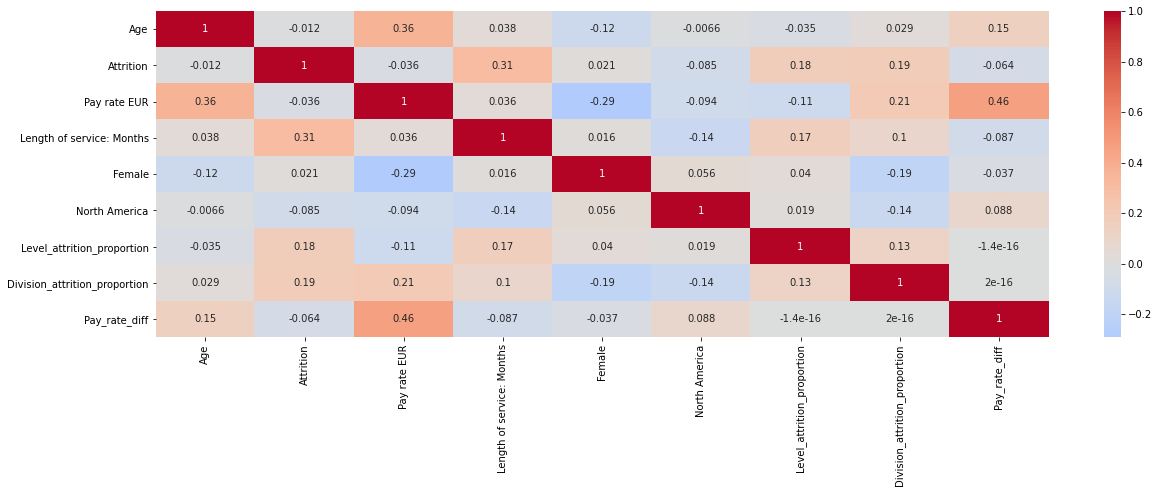

In [122]:
plt.rcParams['figure.figsize'] = (20,6)
_ = sns.heatmap(data=df.corr(), cmap='coolwarm', center=0, annot=True)

### Scaling

In [123]:
sc = StandardScaler()

In [124]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))
data_scaled

array([[-1.08709891e+00, -2.34168476e+00, -1.23211348e+00, ...,
         3.09630929e-01, -1.64728826e-01, -2.92075138e+00],
       [-5.11264630e-01, -1.93184965e+00, -9.61543397e-01, ...,
         3.09630929e-01, -1.64728826e-01, -2.03073217e+00],
       [-1.27375108e-01, -1.47795118e+00, -6.90973317e-01, ...,
         3.09630929e-01, -1.64728826e-01, -1.04502270e+00],
       ...,
       [ 2.17596202e+00,  1.26750413e+00, -4.20403236e-01, ...,
        -1.72670977e-01, -7.39167808e-01, -1.49729067e-16],
       [ 2.17596202e+00,  1.26750413e+00, -4.88045756e-01, ...,
        -7.33111181e-01, -7.39167808e-01, -1.49729067e-16],
       [ 1.02429346e+00,  2.46938945e+00,  7.29519606e-01, ...,
         5.60212366e-01,  1.61080985e+00, -1.49729067e-16]])

In [125]:
X = data_scaled
y = df_num['Attrition']

## Model testing

Note about confusion matrix: A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right). Example trying to predict 5 (positive, 1) vs other numbers (negative, 0)

![abc](Captura.PNG)

### LogisticRegression, RandomForest, SVM, VotingClassifier

In [126]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [127]:
X = data_scaled
y = df_num['Attrition']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [130]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [131]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

LogisticRegression 0.8073394495412844 
 [[79 15]
 [ 6  9]] 
               precision    recall  f1-score   support

           0       0.93      0.84      0.88        94
           1       0.38      0.60      0.46        15

    accuracy                           0.81       109
   macro avg       0.65      0.72      0.67       109
weighted avg       0.85      0.81      0.82       109

RandomForestClassifier 0.7706422018348624 
 [[75 15]
 [10  9]] 
               precision    recall  f1-score   support

           0       0.88      0.83      0.86        90
           1       0.38      0.47      0.42        19

    accuracy                           0.77       109
   macro avg       0.63      0.65      0.64       109
weighted avg       0.79      0.77      0.78       109

SVC 0.7889908256880734 
 [[78 16]
 [ 7  8]] 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        94
           1       0.33      0.53      0.41        15

    accura

Voting Classifier is the model with the highest recall and the best accuracy

### Naive Bayes

In [132]:
X = df_num.drop(columns=['Attrition', 'Pay_rate_diff'], axis=1)
y = df_num['Attrition']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
cnb = ComplementNB()
mnb = MultinomialNB()
gnb = GaussianNB()

In [135]:
for clf in (gnb, cnb, mnb):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n',
          classification_report(y_pred, y_test))

GaussianNB 0.7889908256880734 
 [[78 16]
 [ 7  8]] 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        94
           1       0.33      0.53      0.41        15

    accuracy                           0.79       109
   macro avg       0.63      0.68      0.64       109
weighted avg       0.84      0.79      0.81       109

ComplementNB 0.6422018348623854 
 [[56 10]
 [29 14]] 
               precision    recall  f1-score   support

           0       0.66      0.85      0.74        66
           1       0.58      0.33      0.42        43

    accuracy                           0.64       109
   macro avg       0.62      0.59      0.58       109
weighted avg       0.63      0.64      0.61       109

MultinomialNB 0.6972477064220184 
 [[63 11]
 [22 13]] 
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        74
           1       0.54      0.37      0.44        35

    accuracy      

### xgboost

data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

X = data_scaled
y = df_num['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

from xgboost import XGBClassifier

xgb = XGBClassifier(
      max_depth=2,
      gamma=2,
      eta=0.8,
      reg_alpha=0.5,
      reg_lambda=0.5)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(xgb.__class__.__name__, accuracy_score(y_test, y_pred), '\n', confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

## Final model - Voting Classifier

In [136]:
random_df = df.sample(frac=1)

In [137]:
df_num = random_df.select_dtypes('number')
df_num

,Age,Attrition,Pay rate EUR,Length of service: Months,Female,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff
EEID,,,,,,,,,
688,35,0,44000.0,5,0,0,0.248588,0.380208,-4801.808108
215,28,1,29621.0,44,0,0,0.302326,0.292683,-1672.923077
420,42,1,40000.0,48,1,0,0.235294,0.231884,-7066.666667
737,33,0,40672.0,2,1,1,0.181818,0.250000,0.000000
477,33,1,30000.0,11,0,0,0.314338,0.380208,-4231.750000
...,...,...,...,...,...,...,...,...,...
406,40,1,41600.0,27,0,0,0.314338,0.380208,7368.250000
674,35,0,44000.0,7,1,0,0.248588,0.300000,4738.327273
673,33,0,30400.0,6,0,0,0.302326,0.292683,-893.923077


In [138]:
data_scaled = sc.fit_transform(df_num.drop('Attrition', axis=1))

In [139]:
X = data_scaled
y = df_num['Attrition']

In [140]:
X_test = X[:109]
X_train = X[109:]
y_test = y[:109]
y_train = y[109:]

In [141]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [142]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

In [143]:
print(voting_clf.__class__.__name__, accuracy_score(y_test, y_pred), '\n',
      confusion_matrix(y_pred, y_test), '\n', classification_report(y_pred, y_test))

VotingClassifier 0.7339449541284404 
 [[68 28]
 [ 1 12]] 
               precision    recall  f1-score   support

           0       0.99      0.71      0.82        96
           1       0.30      0.92      0.45        13

    accuracy                           0.73       109
   macro avg       0.64      0.82      0.64       109
weighted avg       0.90      0.73      0.78       109



## Visualization: ipywidgets

In [144]:
new_df = random_df[:109]

In [145]:
new_df['Attrition_pred'] = y_pred

In [146]:
new_df

,Status,Age,Gender,Attrition,Location,Division,Pay rate EUR,Level,Length of service: Months,Female,North America,Level_attrition_proportion,Division_attrition_proportion,Pay_rate_diff,Attrition_pred
EEID,,,,,,,,,,,,,,,
688,Active,35,Male,0,Europe,Engineering,44000.00,E3,5,0,0,0.248588,0.380208,-4801.808108,0
215,Inactive,28,Male,1,Europe,Design,29621.00,E2,44,0,0,0.302326,0.292683,-1672.923077,0
420,Inactive,42,Female,1,Europe,Customer Success,40000.00,M2,48,1,0,0.235294,0.231884,-7066.666667,0
737,Active,33,Female,0,North America,Business Development,40672.00,E4,2,1,1,0.181818,0.250000,0.000000,0
477,Inactive,33,Male,1,Europe,Engineering,30000.00,Unknown,11,0,0,0.314338,0.380208,-4231.750000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,Active,38,Male,0,Europe,Engineering,42400.00,E3,3,0,0,0.248588,0.380208,-6401.808108,0
519,Inactive,37,Male,0,Europe,Engineering,61600.00,E3,12,0,0,0.248588,0.380208,12798.191892,0
626,Active,40,Male,0,North America,Customer Success,19929.28,E2,11,0,1,0.302326,0.231884,-5025.841191,0


In [147]:
new_df = new_df[new_df['Level'] != 'Unknown']

In [148]:
cols_to_visualize = ['Age', 'Level', 'Gender', 'Location']

In [149]:
new_df.groupby('Division')['Attrition_pred'].count().sort_values(ascending=False).iplot(kind='bar')

In [150]:
@interact(division=new_df['Division'].sort_values(ascending=True).unique(), x=cols_to_visualize)
def explore(division, x):
    division_df = new_df[new_df['Division'] == division]
    division_df.groupby(x)['Attrition_pred'].count().sort_values(ascending=False).iplot(kind='bar')

interactive(children=(Dropdown(description='division', options=('Business Development', 'Customer Success', 'D…